In [ ]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pysm3.units as u
from pysm3.models.cmb import (
    CMBMap,
    simulate_tebp_correlated,
    offset_pos, taylor_interpol_iter,
    apply_rotation
)

from pysm3.models.cmb import CMBLensed as CMBLensedOriginal

In [7]:
def build_tebp_dl2cl_scale(lmax):
    """
    Builds scale factors for converting between bandpower and angular
    power spectrum.
    """
    ell = np.arange(2, lmax + 1)

    scale = np.zeros([10, ell.size]) 
    scale[0] = 2 * np.pi / (ell * (ell + 1))         # TT
    scale[1] = 2 * np.pi / (ell * (ell + 1))         # EE
    scale[2] = 2 * np.pi / (ell * (ell + 1))         # BB
    scale[3] = 2 * np.pi / (ell * (ell + 1)) ** 2    # PP
    scale[4] = 2 * np.pi / (ell * (ell + 1))         # TE
    scale[5] = 2 * np.pi / (ell * (ell + 1))         # EB
    scale[6] = 2 * np.pi / (ell * (ell + 1))         # BP
    scale[7] = 2 * np.pi / (ell * (ell + 1))         # TB
    scale[8] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # EP
    scale[9] = 2 * np.pi / (ell * (ell + 1)) ** 1.5  # TP

    return scale


def camb2tebp(camb_dl, delens_ells=None):
    """
    Converts CAMB output to the TEBP format expected by the Taylens code

    Assumptions:
    - Multipoles are in order, non-repeating, continuous
    - CAMB output is L, TT, EE, BB, TE, PP, TP, EP
    - Multipoles start at 2
    """
    lmax = int(camb_dl[0][-1])  # Last value in the first column (L)

    # Dipoles start at 2; need lmax-2 values -> shape of ells would be lmax-1
    _cl_tebp_arr = np.zeros([10, lmax - 1])
    _cl_tebp_arr[0] = camb_dl[1]  # TT
    _cl_tebp_arr[1] = camb_dl[2]  # EE
    _cl_tebp_arr[2] = camb_dl[3]  # BB
    _cl_tebp_arr[3] = camb_dl[5]  # PP
    _cl_tebp_arr[4] = camb_dl[4]  # TE
    _cl_tebp_arr[5] = 0      # EB
    _cl_tebp_arr[6] = 0      # BP
    _cl_tebp_arr[7] = 0      # TB
    _cl_tebp_arr[8] = camb_dl[7]  # EP
    _cl_tebp_arr[9] = camb_dl[6]  # TP

    scale = build_tebp_dl2cl_scale(lmax)
    _cl_tebp_arr *= scale

    if delens_ells is not None:
        # Multiply the lensing power spectrum by the delensing factor
        _cl_tebp_arr[3] *= delens_ells[1]
        _cl_tebp_arr[8] *= np.sqrt(delens_ells[1])
        _cl_tebp_arr[9] *= np.sqrt(delens_ells[1])

    # Create final array with zeros for monopole and dipole
    cl_tebp_arr = np.zeros((10, lmax + 1))
    cl_tebp_arr[:, 2:] = _cl_tebp_arr

    return cl_tebp_arr

class CMBLensed(CMBMap):
    # inherit from CMBMap so we get the `get_emission` method
    def __init__(
        self,
        nside,
        cmb_spectra,
        max_nside=None,
        cmb_seed=None,
        apply_delens=False,
        delensing_ells=None,
        map_dist=None,
    ):
        """Lensed CMB

        Takes an input unlensed CMB and lensing spectrum from CAMB and uses
        Taylens to apply lensing, it optionally simulates delensing by
        suppressing the lensing power at specific scales with the user
        provided `delensing_ells`.

        Parameters
        ----------

        cmb_spectra : path
            Input text file from CAMB, spectra unlensed
        cmb_seed : int
            Numpy random seed for synfast, set to None for a random seed
        apply_delens : bool
            If true, simulate delensing with taylens
        delensing_ells : path
            Space delimited file with ells in the first columns and suppression
            factor (1 for no suppression) in the second column
        """
        try:
            super().__init__(nside=nside, max_nside=max_nside, map_dist=map_dist)
        except ValueError:
            pass  # suppress exception about not providing any input map
        self.cmb_spectra = self.read_txt(cmb_spectra, unpack=True)
        self.cmb_seed = cmb_seed
        self.apply_delens = apply_delens
        self.delensing_ells = (
            None if delensing_ells is None else self.read_txt(delensing_ells, unpack=True)
        )

        # Remove monopole and dipole, if present
        if self.cmb_spectra[0][0] == 0:
            self.cmb_spectra = self.cmb_spectra[:, 2:]
        if self.apply_delens and self.delensing_ells[0][0] == 0:
            self.delensing_ells = self.delensing_ells[:, 2:]
        # Ensure multipoles are the same length if delensing
        if self.apply_delens:
            ell_delens  = self.delensing_ells[0]
            ell_spectra = self.cmb_spectra[0]
            if not np.array_equal(ell_delens, ell_spectra):
                # Multipoles do not match
                raise ValueError(f"Multipoles do not match for cmb_spectra and delensing ells.")

        self.map = u.Quantity(self.run_taylens(), unit=u.uK_CMB, copy=False)

    def run_taylens(self):
        """Returns CMB (T, Q, U) maps as a function of observing frequency, nu.

        This code is extracted from the taylens code (reference).

        :return: function -- CMB maps.
        """
        synlmax = 8 * self.nside  # this used to be user-defined.
        lmax_cl = self.cmb_spectra[0][-1]  # Get the maximum l from the input spectra
        ell = np.arange(int(lmax_cl + 1))
        synlmax = min(synlmax, ell[-1])

        # Convert the input spectra to the format used by taylens
        cl_tebp_arr = camb2tebp(self.cmb_spectra, self.delensing_ells)

        # Coordinates of healpix pixel centers
        ipos = np.array(hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside))))

        # Simulate a CMB and lensing field
        cmb, aphi = simulate_tebp_correlated(
            cl_tebp_arr, self.nside, synlmax, self.cmb_seed
        )

        if cmb.ndim == 1:
            cmb = np.reshape(cmb, [1, cmb.size])

        # Compute the offset positions
        phi, phi_dtheta, phi_dphi = hp.alm2map_der1(aphi, self.nside, lmax=synlmax)

        del aphi

        opos, rot = offset_pos(
            ipos, phi_dtheta, phi_dphi, pol=True, geodesic=False
        )  # geodesic used to be used defined.
        del phi, phi_dtheta, phi_dphi

        # Interpolate maps one at a time
        maps = []
        for comp in cmb:
            for m in taylor_interpol_iter(
                comp, opos, 3, verbose=False, lmax=None
            ):  # lmax here needs to be fixed. order of taylor expansion is fixed to 3.
                pass
            maps.append(m)
        del opos, cmb
        return np.array(apply_rotation(maps, rot))


In [8]:
def compare_maps(params, cmbl1 = CMBLensedOriginal, cmbl2 = CMBLensed, label1="Original", label2="Revised"):
    m1 = cmbl1(**params).map
    m2 = cmbl2(**params).map
    fig, axs = plt.subplots(3, 3, figsize=(12, 8))
    plt.sca(axs[0,0])
    hp.mollview(m2[0], title=f"{label1} T", hold=True)
    plt.sca(axs[0,1])
    hp.mollview(m2[1], title=f"{label1} Q", hold=True)
    plt.sca(axs[0,2])
    hp.mollview(m2[2], title=f"{label1} U", hold=True)
    plt.sca(axs[1,0])
    hp.mollview(m1[0], title=f"{label2} T", hold=True)
    plt.sca(axs[1,1])
    hp.mollview(m1[1], title=f"{label2} Q", hold=True)
    plt.sca(axs[1,2])
    hp.mollview(m1[2], title=f"{label2} U", hold=True)
    plt.sca(axs[2,0])
    hp.mollview(m1[0] - m2[0], title="Delta T", hold=True)
    plt.sca(axs[2,1])
    hp.mollview(m1[1] - m2[1], title="Delta Q", hold=True)
    plt.sca(axs[2,2])
    hp.mollview(m1[2] - m2[2], title="Delta U", hold=True)
    plt.show()

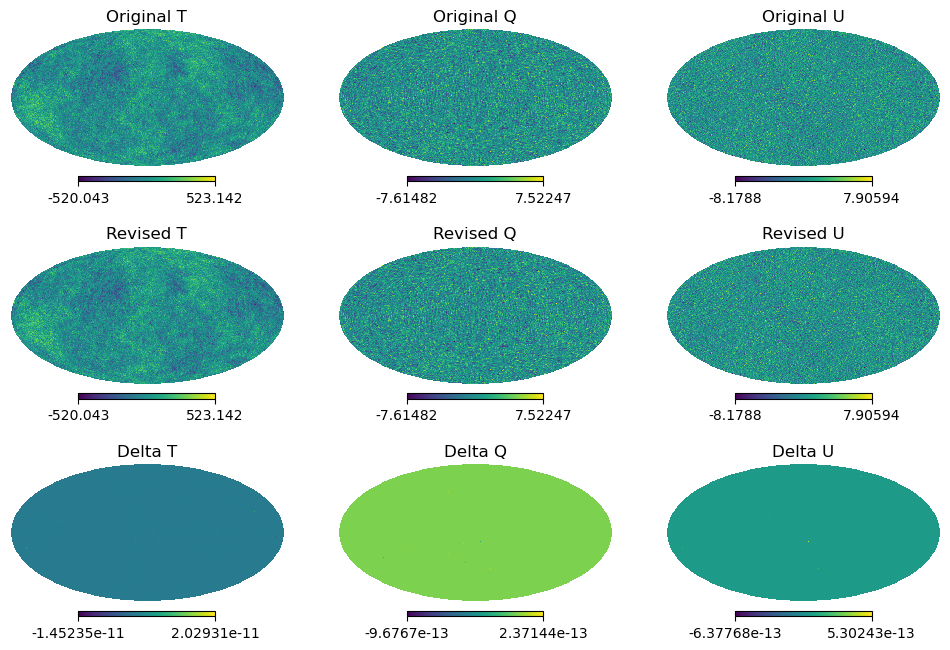

In [9]:
params = dict(
    nside=128,
    cmb_spectra="demo_powerspectra/c1_ps.dat",
    max_nside=None,
    cmb_seed=0,
    apply_delens=False,
    delensing_ells=None,
    map_dist=None,
)
compare_maps(params)

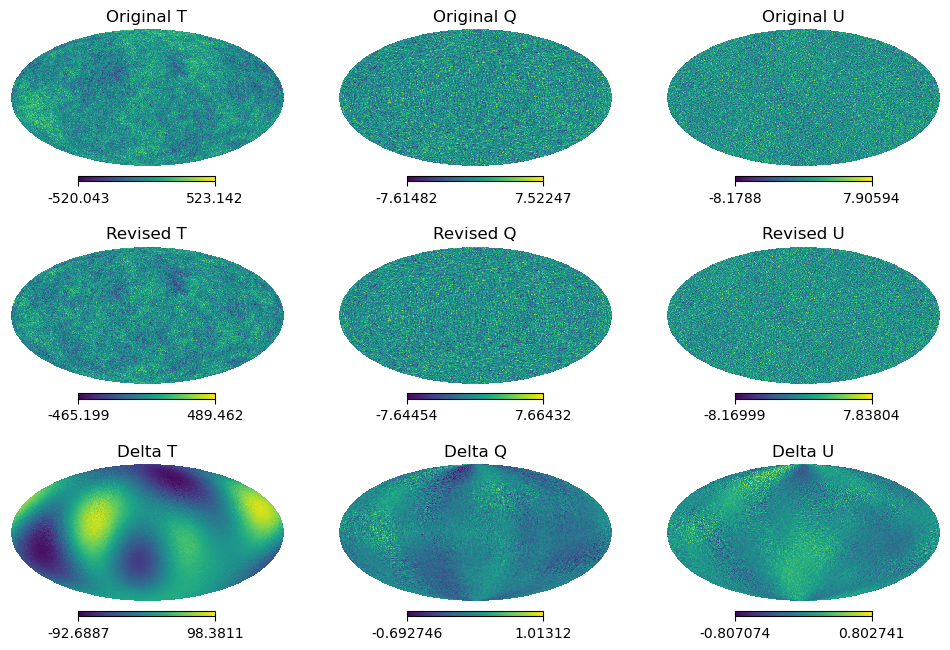

In [10]:
params = dict(
    nside=128,
    cmb_spectra="demo_powerspectra/c1_ps_l01.dat",
    max_nside=None,
    cmb_seed=0,
    apply_delens=False,
    delensing_ells=None,
    map_dist=None,
)
compare_maps(params)

# With `apply_delens`

In [11]:
params = dict(
    nside=128,
    cmb_spectra="demo_powerspectra/c1_ps_l01.dat",
    max_nside=None,
    cmb_seed=0,
    apply_delens=True,
    delensing_ells="demo_powerspectra/c1_delensing_ells.dat",
    map_dist=None,
)

try:
    compare_maps(params)
except ValueError as e:
    print(e)

operands could not be broadcast together with shapes (2201,) (2,) 


In [12]:
class SurrogateCMBLensed(CMBMap):
    # inherit from CMBMap so we get the `get_emission` method
    def __init__(
        self,
        nside,
        cmb_spectra,
        max_nside=None,
        cmb_seed=None,
        apply_delens=False,
        delensing_ells=None,
        map_dist=None,
    ):
        """Lensed CMB

        Takes an input unlensed CMB and lensing spectrum from CAMB and uses
        Taylens to apply lensing, it optionally simulates delensing by
        suppressing the lensing power at specific scales with the user
        provided `delensing_ells`.

        Parameters
        ----------

        cmb_spectra : path
            Input text file from CAMB, spectra unlensed
        cmb_seed : int
            Numpy random seed for synfast, set to None for a random seed
        apply_delens : bool
            If true, simulate delensing with taylens
        delensing_ells : path
            Space delimited file with ells in the first columns and suppression
            factor (1 for no suppression) in the second column
        """
        try:
            super().__init__(nside=nside, max_nside=max_nside, map_dist=map_dist)
        except ValueError:
            pass  # suppress exception about not providing any input map
        self.cmb_spectra = self.read_txt(cmb_spectra, unpack=True)
        self.cmb_seed = cmb_seed
        self.apply_delens = apply_delens
        self.delensing_ells = (
            None if delensing_ells is None else self.read_txt(delensing_ells, unpack=True)
        )
        self.map = u.Quantity(self.run_taylens(), unit=u.uK_CMB, copy=False)

    def run_taylens(self):
        pass

SurrogateCMBLensed.run_taylens = CMBLensedOriginal.run_taylens

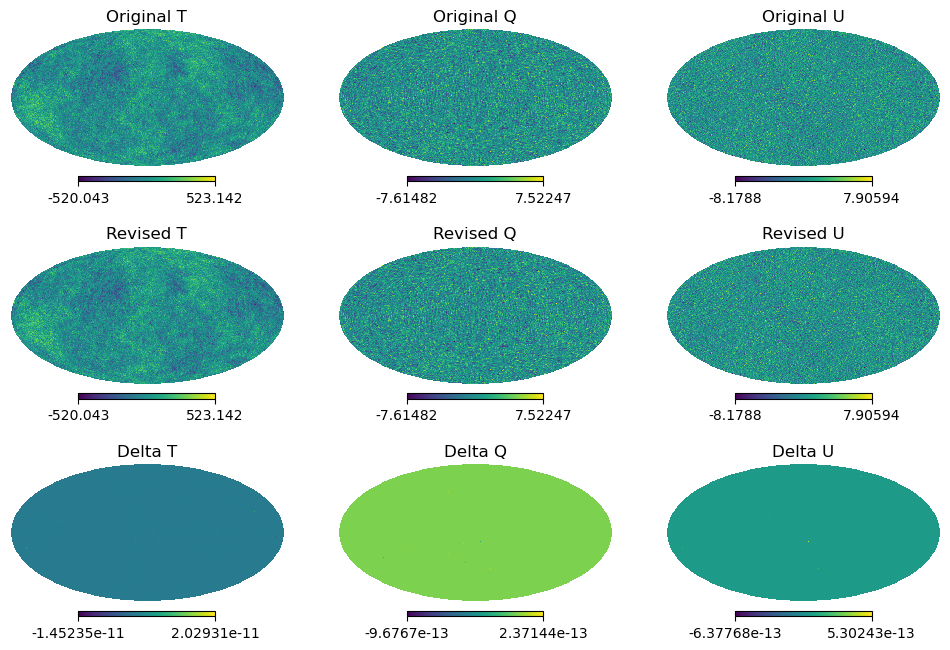

In [13]:
params = dict(
    nside=128,
    cmb_spectra="demo_powerspectra/c1_ps.dat",
    max_nside=None,
    cmb_seed=0,
    apply_delens=True,
    delensing_ells="demo_powerspectra/c1_delensing_ells.dat",
    map_dist=None,
)

compare_maps(params, cmbl1=SurrogateCMBLensed)

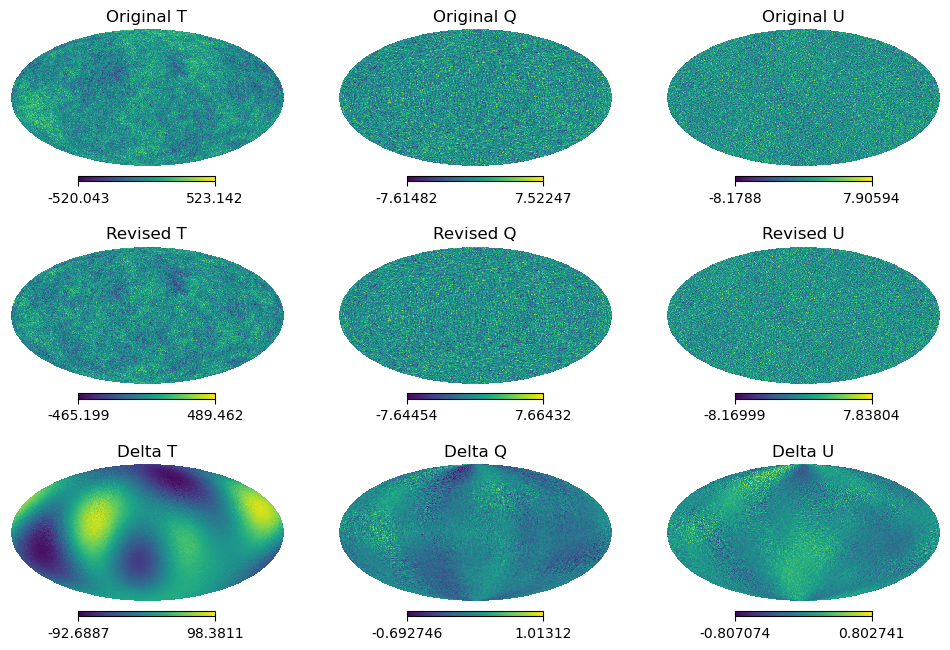

In [15]:
params = dict(
    nside=128,
    cmb_spectra="demo_powerspectra/c1_ps_l01.dat",
    max_nside=None,
    cmb_seed=0,
    apply_delens=True,
    delensing_ells="demo_powerspectra/c1_delensing_ells_l01.dat",
    map_dist=None,
)

compare_maps(params, cmbl1=SurrogateCMBLensed)